In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np

df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete2.csv')
# 预测第二天用药，第一天当做历史信息
x = df.iloc[:,5:5+72+2000+300]
y = df.iloc[:,5+72+2000+300:5+72+2000+300+300]


# 将字符串类型的数据转化为数值
from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])


# 填补缺失值，用平均值
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)
y = np.array(y)

#标准化数据
from sklearn.preprocessing import scale
x = scale(x)

# 划分数据集
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# X_train = X_train.astype(np.float64)
# X_test = X_test.astype(np.float64)
# y_train = y_train.astype(np.int32)
# y_test = y_test.astype(np.int32)




In [2]:
from keras import backend as K
from keras import losses
from keras.layers import Dropout
import numpy as np
import tensorflow as tf
from keras import losses
def JI(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
#     K.print_tensor(y_true, message='y_true = ')

    threshold_value = 0.3

    y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#     K.print_tensor(y_pred, message='y_pred = ')
    fenzi = K.sum(y_true * y_pred, keepdims=True)
#     K.print_tensor(fenzi, message='fenzi = ')
    # true_positives_sum = K.sum(true_positives, keepdims=True)
    fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

    return K.mean(fenzi / fenmu, axis=-1)



def deep_model(feature_dim,label_dim, layer_num=1):

    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
def train_DNN(X_train,y_train,X_test,y_test, 
               layer_num=1, 
               callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],
               optimizer='adam', 
               metrics=[JI],
               hidden_layer_num=1,
               hidden_layer_units=512,
               batch_size=256, 
               epochs=500,
               hidden_layer_dropout = False,
               input_layer_dropout = False,
               dropout_rate = 0.2,
               use_kernel_regularizer = False,
              kernel_regularizer = keras.regularizers.l2(0.001)
               ):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    if input_layer_dropout:
        model.add(Dropout(dropout_rate, input_shape=(feature_dim,)))
    else:
        model.add(Dense(hidden_layer_units, activation='relu', input_dim=feature_dim))
    for i in range(hidden_layer_num):
        if hidden_layer_dropout:
            model.add(Dropout(dropout_rate))
        if use_kernel_regularizer:
            model.add(Dense(hidden_layer_units, activation='relu',kernel_regularizer=kernel_regularizer))
        else:
            model.add(Dense(hidden_layer_units, activation='relu'))
        
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    JI_list = history.history['val_JI']
    print( "验证集上的最优结果是%s,对应训练轮次是%d" % (max(JI_list),JI_list.index(max(JI_list))+1) )
    return max(JI_list)




In [3]:
# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

create model. feature_dim =2372, label_dim =300
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1214976   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 300)               153900    
                                                                 
Total params: 1,631,532
Trainable params: 1,631,532
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
110/110 [==============================] - 3s 20ms/step - loss: 0.1261 - JI: 0.0866 - val_loss: 0.0895 - val_JI: 0.1242
Epoch 2/200
110/110 [==============================] - 2s 17ms/step - loss: 0.0803 - JI: 0.1807 - val_loss: 0.0843 - val_JI: 0.156

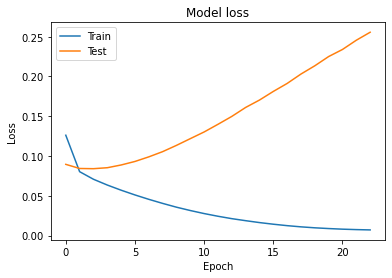

验证集上的最优结果是0.18095311522483826,对应训练轮次是4


0.18095311522483826

In [4]:
train_DNN(X_train,y_train,X_test,y_test,epochs=200)

In [ ]:
train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [],epochs=200,hidden_layer_num=3, use_kernel_regularizer=True)

In [ ]:
train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],epochs=200,hidden_layer_num=3, input_layer_dropout=True)

In [ ]:
train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],epochs=200,hidden_layer_num=3, hidden_layer_dropout=True)

In [ ]:
train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],epochs=200,hidden_layer_num=3, hidden_layer_dropout=True, use_kernel_regularizer=True)

In [ ]:
train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],epochs=200,hidden_layer_num=3, hidden_layer_dropout=True, use_kernel_regularizer=True,kernel_regularizer = keras.regularizers.l2(0.0001))

In [ ]:
train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20),
                                                             keras.callbacks.ReduceLROnPlateau(
     # This callback will monitor the validation loss of the model
     monitor='val_loss',
     # It will divide the learning by 10 when it gets triggered
     factor=0.1,
     # It will get triggered after the validation loss has stopped improving
     # for at least 10 epochs
     patience=10,
    ),],epochs=200,hidden_layer_num=3, hidden_layer_dropout=True, use_kernel_regularizer=True,kernel_regularizer = keras.regularizers.l2(0.0001))

In [ ]:
train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20),
                                                             keras.callbacks.ReduceLROnPlateau(
     # This callback will monitor the validation loss of the model
     monitor='val_loss',
     # It will divide the learning by 10 when it gets triggered
     factor=0.1,
     # It will get triggered after the validation loss has stopped improving
     # for at least 10 epochs
     patience=10,
    ),],epochs=200,hidden_layer_num=3, hidden_layer_dropout=True, use_kernel_regularizer=True,kernel_regularizer = keras.regularizers.l2(0.0001), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
# 参数调节
import tensorflow as tf
lr_list = [1,0.1,0.01,0.001,0.0001]

optimizer_list = []
for i in lr_list:
    optimizer_list.append(tf.keras.optimizers.SGD(learning_rate=i))
    optimizer_list.append(tf.keras.optimizers.Adagrad(learning_rate=i))
    optimizer_list.append(tf.keras.optimizers.Adadelta(learning_rate=i))
    optimizer_list.append(tf.keras.optimizers.Adam(learning_rate=i))

hidden_layer_num_list=[1,2,3,4,5,6,7,8]
hidden_layer_units_list=[512,256,128,64,32,16]
batch_size_list=[512,256,128,64]
hidden_layer_dropout_list = [True,False]
input_layer_dropout_list = [True,False]
dropout_rate_list = [0.1,0.2,0.3,0.4,0.5]
use_kernel_regularizer_list = [True,False]
re_cof_list = [1,0.1,0.01,0.001,0.0001,0.00001,0.000001]
kernel_regularizer_list = []
for i in re_cof_list:
    kernel_regularizer_list.append(tf.keras.regularizers.l1(i))
    kernel_regularizer_list.append(tf.keras.regularizers.l2(i))





In [ ]:
results = []
# 调正则化参数
for re in kernel_regularizer_list:
    results.append(train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],use_kernel_regularizer = True,kernel_regularizer = re))
results
    


In [ ]:
results = []
# 调dropout
for dropout_rate in [0.1,0.2,0.3,0.4,0.5]:
    results.append(train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],hidden_layer_dropout = True,dropout_rate = dropout_rate))
results
    

In [ ]:
results = []
# 调dropout
for dropout_rate in [0.1,0.2,0.3,0.4,0.5]:
    results.append(train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],input_layer_dropout = True,dropout_rate = dropout_rate))
results
    

In [ ]:
# 不同JI阈值
results = []
for threshold in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    def JI(y_true, y_pred):
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
#         K.print_tensor(y_true, message='y_true = ')

        threshold_value = threshold

        y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#         K.print_tensor(y_pred, message='y_pred = ')
        fenzi = K.sum(y_true * y_pred, keepdims=True)
        # true_positives_sum = K.sum(true_positives, keepdims=True)
        fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

        return K.mean(fenzi / fenmu, axis=-1)
    results.append(train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],metrics=[JI]))

In [ ]:
results

In [ ]:
train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],metrics=['acc',JI])

In [ ]:
train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)])